#### CPD Citation Data: Initial Descriptive Analysis

_May 2022_

The purpose of this notebook is to carry out an initial inspection of [the CPD citation data available on the Chicago Data Portal](https://data.cityofchicago.org/Public-Safety/Police-ANOV-Misdemeanor-Report-ANOVs/bi66-5gy5), retrieved 2 May 2022. The dataset spans 2015-2020 and was last updated in 2021.

In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib as plt
from datetime import datetime
import seaborn as sb
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 12]  # add more space to figures

In [4]:
data = pd.read_csv(
    "data/Citations_22May2.csv",
    parse_dates=["ISSUED DATE"],
    dayfirst=False  # date is in format mm/dd/yyyy
    )

In [3]:
data

,NOV NUMBER,ISSUED DATE,STREET NUMBER,STREET DIRECTION,STREET NAME,UNIT NUMBER,VIOLATION DESCRIPTION,LOCATION
0,P004672202,2015-08-02,0,W,95TH ST,701,1,NaN
1,P004978399,2016-03-18,0,W,95ST,701,1,NaN
2,P005051519,2016-05-24,0,W,69TH,711,1,NaN
3,P004799574,2016-11-19,900,W,HOLLYWOOD,20,1,NaN
4,P005228305,2017-08-04,0,W,TERMINAL,50,1,NaN
...,...,...,...,...,...,...,...,...
649740,P005823923,2020-08-25,0,W,79TH ST,19,0000 - NON-MATCHING VIOLATION RECEIVED FROM EX...,NaN
649741,P005889730,2020-11-21,2200,S,MICHIGAN,1,7-28-227 CONSTRUCTION SITES-GARBAGE,POINT (-87.623802 41.852652)
649742,P006005048,2020-09-02,0,W,95TH ST,701,10-8-526/016-110-1.18 SMOKING ON CTA (INCLUDI...,NaN
649743,P005939260,2020-07-28,100,N,STATE ST,701,8-4-030(A) DRINKING IN PUBLIC WAY.,POINT (-87.627921 41.883328)


Each row is an "administrative notice of violation" (ANOV), that is, a citation. ("NOV" = Notice of Violation). The first column is the ANOV report number. The violation description describes the Municipal Code of Chicago ordinance violated. From the online variable descriptions: "A code of '1' stands for 'OTHER', and means that the code entered didn't match any code that the Department of Administrative Hearings uses to identify a violation."

Street numbers have been altered to show the range of 100 addresses but not the specific address. It is unclear whether this is also true for the location. I will later inspect the shapefile versions of the same data too.

Unit number refers to the CPD unit number. I am not sure what an authoritative reference for these is - I found a third-party one of unknown veracity [here](https://directives.crimeisdown.com/diff/efaff1a7e94a8ad642c793993e0d6701c1d276fd/directives/data/a7a57be2-129add9f-15f12-9add-9fea37e07625ed82.html). 

In [4]:
data.agg({
    "ISSUED DATE":["min","max","median","mean",],
})

,ISSUED DATE
min,2015-01-01 00:00:00.000000000
max,2020-12-31 00:00:00.000000000
median,2017-03-12 00:00:00.000000000
mean,2017-04-30 01:10:11.458957056


<AxesSubplot:>

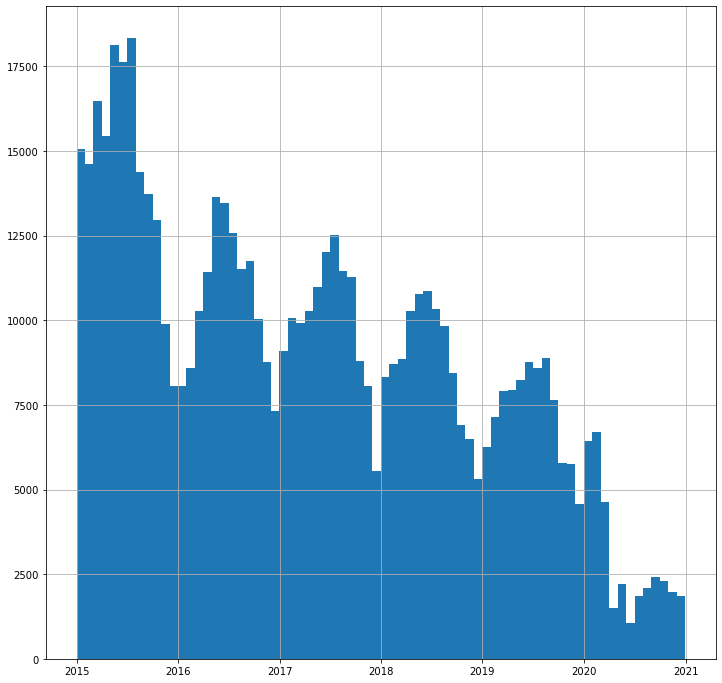

In [4]:
# date histogram
data["ISSUED DATE"].hist(bins=6*12)  # 6 years

That is very strange... why the huge decline in year-over-year citations? The data otherwise look plausible - there's a clear seasonal pattern that matches my expectations, and we can see the impact of COVID in 2020...

<AxesSubplot:>

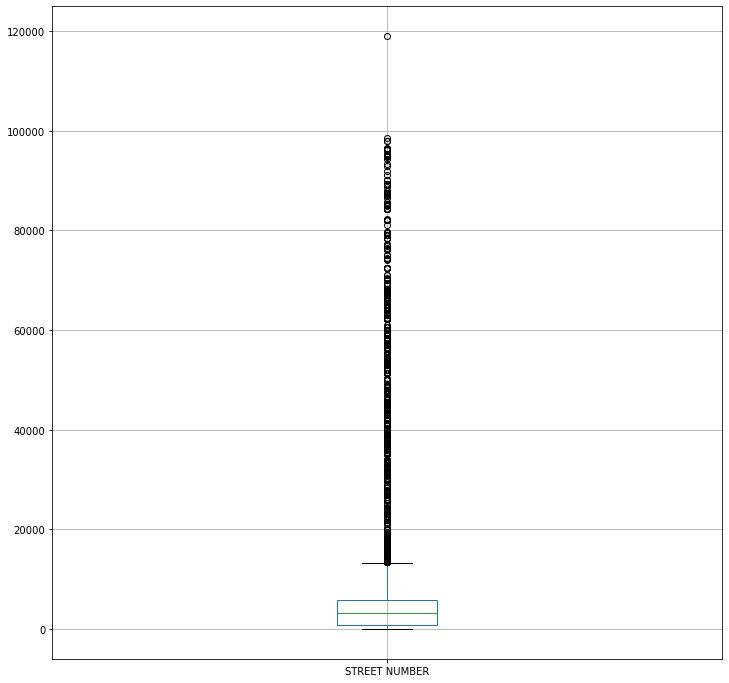

In [5]:
# street number histogram
data.boxplot(column="STREET NUMBER")

In [5]:
print(f'Percent of citations without street address: {round(sum(data["STREET NUMBER"]==0)/len(data)*100,2)}')
print(f'Percent of citations with "Unknown" street: {round(sum(data["STREET NAME"]=="UNKNOWN")/len(data)*100,2)}')
print(f'Percent of citations missing location data: {round(sum(data["LOCATION"].isnull())/len(data)*100,2)}')
print(f'Percent of "Other" citations: {round(sum(data["VIOLATION DESCRIPTION"]=="1")/len(data)*100,2)}')

Percent of citations without street address: 7.06
Percent of citations with "Unknown" street: 0.65
Percent of citations missing location data: 13.54
Percent of "Other" citations: 0.63


In [5]:
# let's add dummy variables for missing data so that we can look at correlations
data["missing_address"] = np.where((data["STREET NUMBER"] == 0),1,0)
data["missing_location"] = np.where(data["LOCATION"].isnull(),1,0)
data['other_violation']= np.where(data["VIOLATION DESCRIPTION"] == "1",1,0)
data

,NOV NUMBER,ISSUED DATE,STREET NUMBER,STREET DIRECTION,STREET NAME,UNIT NUMBER,VIOLATION DESCRIPTION,LOCATION,missing_address,missing_location,other_violation
0,P004672202,2015-08-02,0,W,95TH ST,701,1,NaN,1,1,1
1,P004978399,2016-03-18,0,W,95ST,701,1,NaN,1,1,1
2,P005051519,2016-05-24,0,W,69TH,711,1,NaN,1,1,1
3,P004799574,2016-11-19,900,W,HOLLYWOOD,20,1,NaN,0,1,1
4,P005228305,2017-08-04,0,W,TERMINAL,50,1,NaN,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
649740,P005823923,2020-08-25,0,W,79TH ST,19,0000 - NON-MATCHING VIOLATION RECEIVED FROM EX...,NaN,1,1,0
649741,P005889730,2020-11-21,2200,S,MICHIGAN,1,7-28-227 CONSTRUCTION SITES-GARBAGE,POINT (-87.623802 41.852652),0,0,0
649742,P006005048,2020-09-02,0,W,95TH ST,701,10-8-526/016-110-1.18 SMOKING ON CTA (INCLUDI...,NaN,1,1,0
649743,P005939260,2020-07-28,100,N,STATE ST,701,8-4-030(A) DRINKING IN PUBLIC WAY.,POINT (-87.627921 41.883328),0,0,0


<AxesSubplot:>

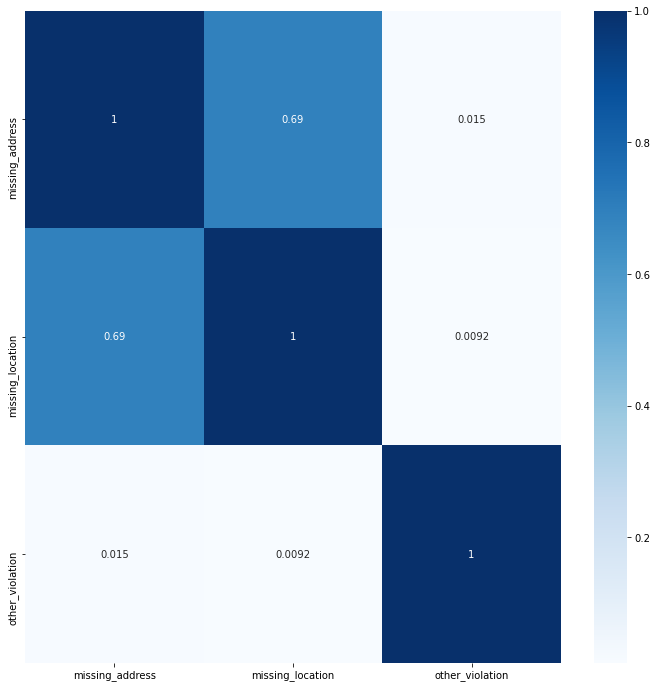

In [14]:
# correlation heatmap
corr = data[["missing_address","missing_location","other_violation"]].corr()
sb.heatmap(corr,cmap="Blues",annot=True)

In [28]:
data.value_counts(["missing_address","missing_location"],normalize=True)

missing_address  missing_location
0                0                   0.864402
1                1                   0.070414
0                1                   0.064952
1                0                   0.000232
dtype: float64

Translation: Most ANOVs have both address and location. 7% have neither. 6% have an address but are missing a location (this is surprising!). Almost none are missing an address but still have a location. 

In [41]:
# inspect some examples of missing location and address
data[((data.missing_address==1) & (data.missing_location==1))]

,NOV NUMBER,ISSUED DATE,STREET NUMBER,STREET DIRECTION,STREET NAME,UNIT NUMBER,VIOLATION DESCRIPTION,LOCATION,missing_address,missing_location,other_violation,ones
0,P004672202,2015-08-02,0,W,95TH ST,701,1,NaN,1,1,1,1
1,P004978399,2016-03-18,0,W,95ST,701,1,NaN,1,1,1,1
2,P005051519,2016-05-24,0,W,69TH,711,1,NaN,1,1,1,1
4,P005228305,2017-08-04,0,W,TERMINAL,50,1,NaN,1,1,1,1
6,P005920753,2018-09-09,0,W,95TH ST,701,1,NaN,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
649728,P006006307,2020-12-29,0,W,87TH ST,620,8-4-030(A) DRINKING IN PUBLIC WAY.,NaN,1,1,0,1
649730,P005940165,2020-10-06,0,W,69TH ST,543,10-8-526/016-110-1.18 SMOKING ON CTA (INCLUDI...,NaN,1,1,0,1
649734,P005930695,2020-07-23,0,E,ILLINOIS,18,8-4-030(A) DRINKING IN PUBLIC WAY.,NaN,1,1,0,1
649740,P005823923,2020-08-25,0,W,79TH ST,19,0000 - NON-MATCHING VIOLATION RECEIVED FROM EX...,NaN,1,1,0,1


In [37]:
# inspect some examples of missing location but with address
data[((data.missing_address==0) & (data.missing_location==1))].head()

,NOV NUMBER,ISSUED DATE,STREET NUMBER,STREET DIRECTION,STREET NAME,UNIT NUMBER,VIOLATION DESCRIPTION,LOCATION,missing_address,missing_location,other_violation,ones
3,P004799574,2016-11-19,900,W,HOLLYWOOD,20,1,NaN,0,1,1,1
5,P005762596,2018-04-17,300,N,ERIE,0,1,NaN,0,1,1,1
8,P004677744,2015-02-05,300,W,CHICAGO,18,8-4-030(A) DRINKING IN PUBLIC WAY.,NaN,0,1,0,1
13,P004378136,2015-01-15,8700,S,CHICAGO SKYWAY TURNAROUND,145,1,NaN,0,1,1,1
15,P004544252,2015-01-08,2000,W,CHICAGO,12,8-4-056(B) FALSE BURGLAR ALARM,NaN,0,1,0,1


In [39]:
# inspect some examples of missing location but with address
data[((data.missing_address==1) & (data.missing_location==0))]

,NOV NUMBER,ISSUED DATE,STREET NUMBER,STREET DIRECTION,STREET NAME,UNIT NUMBER,VIOLATION DESCRIPTION,LOCATION,missing_address,missing_location,other_violation,ones
21673,P004648994,2015-02-25,0,NaN,69TH ST,213,10-8-526/98-126#2.8 SMOKING ON CTA,POINT (-87.632398 41.883229),1,0,0,1
25121,P004572421,2015-02-16,0,NaN,CHICAGO,171,10-8-526/98-126#2.8 SMOKING ON CTA,POINT (-87.632398 41.883229),1,0,0,1
33971,P004770350,2015-04-20,0,NaN,55TH ST,2,10-8-526/98-126#1.14(C) TRESPASS (ON CTA PR...,POINT (-87.632398 41.883229),1,0,0,1
34614,P004725033,2015-04-20,0,NaN,CALUMET PARK,4,10-36-185 VII-B 2. PARK CURFEW.(CHICAGO PAR...,POINT (-87.632398 41.883229),1,0,0,1
43032,P004490233,2015-04-12,0,NaN,UNKNOWN,6,8-4-056(B) FALSE BURGLAR ALARM,POINT (-87.632398 41.883229),1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
628309,P005875036,2019-11-16,0,NaN,ROOSEVELT,701,10-8-526/016-110-1.18 SMOKING ON CTA (INCLUDI...,POINT (-87.632398 41.883229),1,0,0,1
628705,P005790149,2020-01-15,0,NaN,95TH,20,1,POINT (-87.632398 41.883229),1,0,1,1
641672,P006003261,2020-09-17,0,NaN,ROOSEVELT RD,704,10-8-526/016-110-1.04 ALCOHOL CONSUMPTION OR ...,POINT (-87.632398 41.883229),1,0,0,1
647560,P005873804,2020-10-14,0,NaN,WACKER DRIVE,701,8-4-030(A) DRINKING IN PUBLIC WAY.,POINT (-87.632398 41.883229),1,0,0,1


Interestingly, there appear to be streets associated with almost every entry, even some where the address and location are missing. (Although in a few cases there is "Unknown"). Note that entries like "Terminal" (at the airport - same entry has CPD unit 50, the airport unit) and "Calumet Park" also appear in the Street column.

Presumably we could impute location accurately based on address, but it is unclear how accurate/precisely we could rely on location alone when address is missing. Still, it seems that the 7% of data for which both are missing are of greatest concern.

In [58]:
# how many violations are there?
data["VIOLATION DESCRIPTION"].nunique()

1356

In [7]:
data["complete"] = np.where((data["missing_address"] == 0) & (data["missing_location"]==0) & (data["other_violation"]==0),1,0)
print(f'Percent data points complete: {data["complete"].mean()}')
data["no loc/add"] = np.where((data["missing_address"] == 1) & (data["missing_location"]==1),1,0)
print(f'Percent data points missing location AND address: {data["no loc/add"].mean()}')

Percent data points complete: 0.8592324681221094
Percent data points missing location AND address: 0.07041377771279501


In [10]:
# we'll group by violation. 
# this won't let us inspect joint distribution of missingness but for now we'll just look at marginals and % complete

data_byviolation = data.groupby(by=["VIOLATION DESCRIPTION"])
violations = data_byviolation.sum()[["missing_address","missing_location","other_violation","complete","no loc/add"]]
violations["number of violations"] = data_byviolation.count()[["UNIT NUMBER"]]
violations = violations.sort_values(by=["number of violations"],ascending=False)
violations.to_csv("outputs/citation_types.csv")
violations["prop_complete"] = violations["complete"]/violations["number of violations"]
violations["prop no loc/add"] = violations["no loc/add"]/violations["number of violations"]
violations

,missing_address,missing_location,other_violation,complete,no loc/add,number of violations,prop_complete,prop no loc/add
VIOLATION DESCRIPTION,,,,,,,,
8-4-030(A) DRINKING IN PUBLIC WAY.,6531,14669,0,130511,6523,145188,0.898910,0.044928
8-4-056(B) FALSE BURGLAR ALARM,2399,4669,0,44185,2395,48858,0.904355,0.049020
13-12-125 DUTY TO SECURE AND MAINTAIN VACANT BUILDING.,226,2224,0,43502,226,45726,0.951362,0.004942
13-12-140 WATCHMAN REQUIRED,195,2098,0,40307,195,42405,0.950525,0.004599
8-4-081(A) PUBLIC URINATION,2413,4931,0,34502,2411,39435,0.874908,0.061139
...,...,...,...,...,...,...,...,...
4-72-020 LICENSE--REQUIRED. (DAY CARE CENTERS),0,0,0,1,0,1,1.000000,0.000000
9-108-200 - RULE 2.3 (2): HEADLIGHTS REQUIRED,1,1,0,0,1,1,0.000000,1.000000
4-80-020(A) LICENSE REQUIREMENTS - FUNERAL BUSINESS,0,0,0,1,0,1,1.000000,0.000000


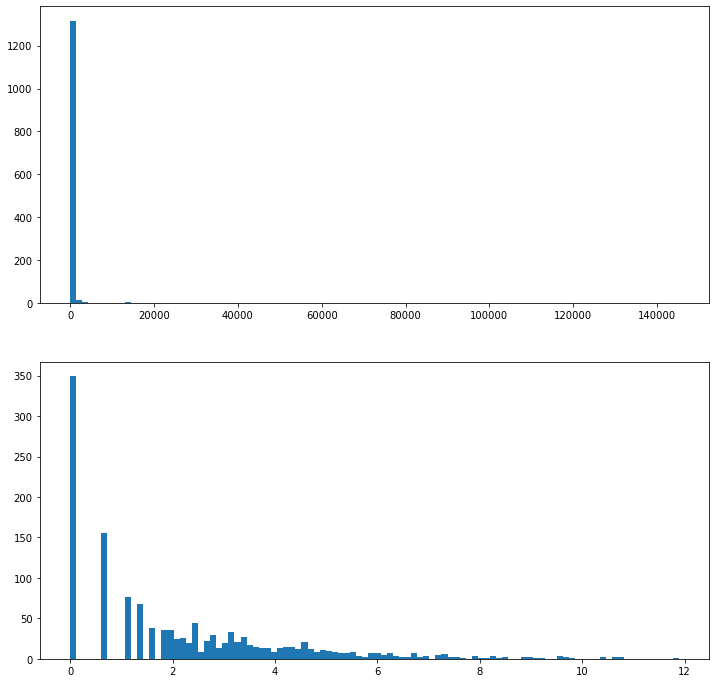

In [9]:
fig, ax = plt.pyplot.subplots(nrows=2)
ax1 = ax[0].hist(violations["number of violations"],bins=100)
violations["log n violations"] = np.log(violations["number of violations"])
ax2 = ax[1].hist(violations["log n violations"],bins=100)

In [116]:
threshold = 30
print(
    f'Percent of violation types: {sum(violations["number of violations"]>threshold)/len(violations)}'
    )
print(f'Number of violation types: {sum(violations["number of violations"]>threshold)}')
print(
    f'Percent of all violations: {sum(violations[violations["number of violations"]>threshold]["number of violations"])/sum(violations["number of violations"])}'
    )

Percent of violation types: 0.2345132743362832
Number of violation types: 318
Percent of all violations: 0.9901930757451


The number of violations per violation type follows a very sharp power-law-esque distribution: half of all of the violations in the dataset are the first five types (drinking in public way, false burglar alarm, duty to secure and maintain public building, watchman required, and public urination). Violation types with at least 10,000 incidents in the dataset comprise just over 1% of the violation types but 3/4 of the incidents in the dataset. The 318 violation types with at least 30 incidents comprise 23.5% of the violation types but 99.0% of the incidents.

Recall that there are 4086 incidents of "Other" violations:

In [128]:
violations[violations["other_violation"] > 0]

,missing_address,missing_location,other_violation,complete,number of violations,prop_complete
VIOLATION DESCRIPTION,,,,,,
1,485,714,4086,0,4086,0.0


In [11]:
violations[["number of violations","complete","prop_complete","prop no loc/add"]].corr()

,number of violations,complete,prop_complete,prop no loc/add
number of violations,1.000000,0.998389,0.011359,-0.011192
complete,0.998389,1.000000,0.016406,-0.014672
prop_complete,0.011359,0.016406,1.000000,-0.750531
prop no loc/add,-0.011192,-0.014672,-0.750531,1.000000


This is good! As a check, there is a strong correlation between absolute # complete and # of violations, and there is a fairly strong inverse correlation between % complete and % no location/address - this makes sense. But there is almost no correlation between % complete or % no location/address and # of violations.

In [13]:
data_byunit = data.groupby(by=["UNIT NUMBER"])
units = data_byunit.sum()[["missing_address","missing_location","other_violation","complete","no loc/add"]]
units["number of violations"] = data_byunit.count()[["VIOLATION DESCRIPTION"]]
units["prop_complete"] = units["complete"]/units["number of violations"]
units["prop no loc/add"] = units["no loc/add"]/units["number of violations"]
units = units.sort_values(by="number of violations",ascending=False)
units.to_csv("outputs/units.csv")
units

,missing_address,missing_location,other_violation,complete,no loc/add,number of violations,prop_complete,prop no loc/add
UNIT NUMBER,,,,,,,,
8,258,2201,184,38317,257,40689,0.941704,0.006316
7,371,1648,200,38540,370,40372,0.954622,0.009165
212,1695,4182,253,35484,1695,39906,0.889190,0.042475
9,318,2208,69,37180,317,39453,0.942387,0.008035
211,2180,4560,294,26884,2177,31705,0.847942,0.068664
...,...,...,...,...,...,...,...,...
472,0,0,0,1,0,1,1.000000,0.000000
451,0,0,0,1,0,1,1.000000,0.000000
447,0,0,0,1,0,1,1.000000,0.000000


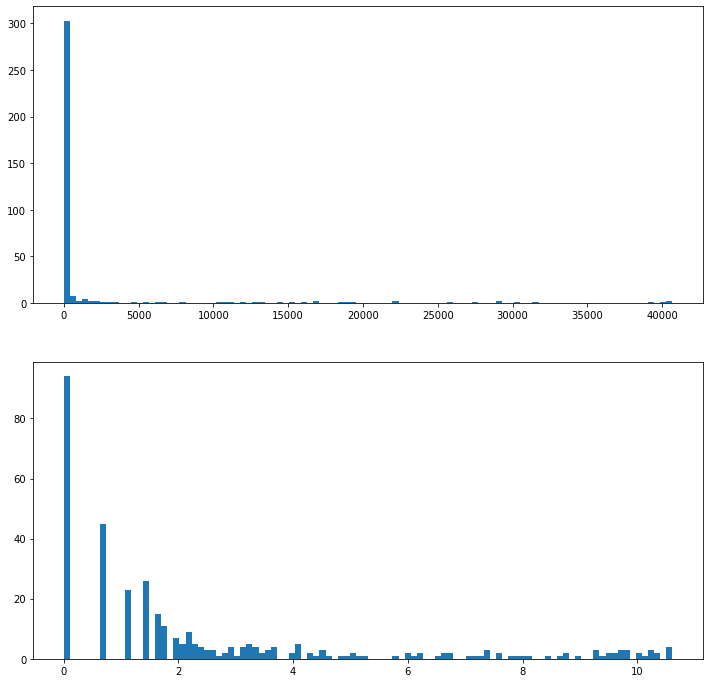

In [146]:
fig, ax = plt.pyplot.subplots(nrows=2)
ax1 = ax[0].hist(units["number of violations"],bins=100)
units["log n violations"] = np.log(units["number of violations"])
ax2 = ax[1].hist(units["log n violations"],bins=100)

In [159]:
threshold = 500
print(
    f'Percent of units: {sum(units["number of violations"]>threshold)/len(units)}'
    )
print(f'Number of units: {sum(units["number of violations"]>threshold)}')
print(
    f'Percent of all violations: {sum(units[units["number of violations"]>threshold]["number of violations"])/sum(units["number of violations"])}'
    )

Percent of units: 0.1384180790960452
Number of units: 49
Percent of all violations: 0.9913519919352977


The citations by unit also follow a power-law-like distribution, though with a bit of a longer tail. 10 units (of 384) with over 25000 citations each gave just over half the citations in the dataset. 26 units with over 10000 citations each gave 89.9% of the citations in the dataset; 49 units with over 500 citations each gave 99.1% of citations.

In [15]:
units[["number of violations","complete","prop_complete","prop no loc/add"]].corr()

,number of violations,complete,prop_complete,prop no loc/add
number of violations,1.000000,0.994431,0.089768,-0.079082
complete,0.994431,1.000000,0.098976,-0.088841
prop_complete,0.089768,0.098976,1.000000,-0.771291
prop no loc/add,-0.079082,-0.088841,-0.771291,1.000000


In [18]:
# fully complete citation types
violations[violations["prop_complete"]==1.0]

,missing_address,missing_location,other_violation,complete,no loc/add,number of violations,prop_complete,prop no loc/add
VIOLATION DESCRIPTION,,,,,,,,
8-32-150(B) GENERAL NOISE LIMITATIONS - ON PRIVATE OPEN,0,0,0,54,0,54,1.0,0.0
4-4-020 LICENSE--REQUIRED FOR BUSINESSES AND OCCUPATIONS,0,0,0,37,0,37,1.0,0.0
10-8-320 POSTING BILLS ON PUBLIC PROPERTY.,0,0,0,35,0,35,1.0,0.0
9-52-070 PARKING.,0,0,0,35,0,35,1.0,0.0
"8-16-020(D) A MINOR IN VEHICLE AFTER CURFEW, UNACCOMPANIED",0,0,0,33,0,33,1.0,0.0
...,...,...,...,...,...,...,...,...
9-110-090(F) PEDICAB LICENSE DECAL - REQUIRED; DECAL NUMBER,0,0,0,1,0,1,1.0,0.0
4-72-020 LICENSE--REQUIRED. (DAY CARE CENTERS),0,0,0,1,0,1,1.0,0.0
4-80-020(A) LICENSE REQUIREMENTS - FUNERAL BUSINESS,0,0,0,1,0,1,1.0,0.0


In [20]:
sum(violations[violations["prop_complete"]==1.0]["number of violations"])

2269

In [19]:
# fully incomplete citation types
violations[violations["prop_complete"]==0.0]

,missing_address,missing_location,other_violation,complete,no loc/add,number of violations,prop_complete,prop no loc/add
VIOLATION DESCRIPTION,,,,,,,,
1,485,714,4086,0,472,4086,0.0,0.115516
9-115-250(C) RULE TNP 6.05 DISTINCTIVE SIGNAGE FOR AIRPORTS,4,5,0,0,4,5,0.0,0.800000
9-115-250(C) RULE TNP 6.02(A) FAILURE TO FOLLOW AIRPORT PRO,2,4,0,0,2,4,0.0,0.500000
9-104-040/RULE 13.03B O'HARE STAGING AREA - UNATTENDED VEH,4,4,0,0,4,4,0.0,1.000000
9-104-040/RULE 1.14 FALSE STATEMENTS ARE PROHIBITED.,4,4,0,0,4,4,0.0,1.000000
...,...,...,...,...,...,...,...,...
4-92-057 LICENSE--DISPLAY. (MASSAGE ESTABLISHMENTS/SERVIC,0,1,0,0,0,1,0.0,0.000000
9-104-110 RULE CH8.01B CHAUFFEURS AND VEHICLES MUST BE IN CO,1,1,0,0,1,1,0.0,1.000000
9-112-180 NON-DISCRIMINATORY PRACTICES (TAXICABS),1,1,0,0,1,1,0.0,1.000000


In [21]:
# not missing any location+address citation types
violations[violations["prop no loc/add"]==0.0]

,missing_address,missing_location,other_violation,complete,no loc/add,number of violations,prop_complete,prop no loc/add
VIOLATION DESCRIPTION,,,,,,,,
8-4-210 SPIKES IN RAILINGS AND FENCES.,0,11,0,493,0,504,0.978175,0.0
13-12-125 (B)(2) FAILURE TO POST A SIGN AFFIXED TO THE BUILD,0,25,0,386,0,411,0.939173,0.0
9-76-210 (B) BROKEN OR INOPERABLE WINDOW; BROKEN OR CRA,0,15,0,178,0,193,0.922280,0.0
10-36-020 ANIMALS PROHIBITED.,0,25,0,153,0,178,0.859551,0.0
7-28-120(A) UNCUT WEEDS.,0,1,0,147,0,148,0.993243,0.0
...,...,...,...,...,...,...,...,...
9-110-090(F) PEDICAB LICENSE DECAL - REQUIRED; DECAL NUMBER,0,0,0,1,0,1,1.000000,0.0
4-72-020 LICENSE--REQUIRED. (DAY CARE CENTERS),0,0,0,1,0,1,1.000000,0.0
4-80-020(A) LICENSE REQUIREMENTS - FUNERAL BUSINESS,0,0,0,1,0,1,1.000000,0.0


In [22]:
sum(violations[violations["prop no loc/add"]==0.0]["number of violations"])

7779

In [24]:
# missing all location+address citation types
violations[violations["prop no loc/add"]==1.0]

,missing_address,missing_location,other_violation,complete,no loc/add,number of violations,prop_complete,prop no loc/add
VIOLATION DESCRIPTION,,,,,,,,
9-104-040/RULE 13.03B O'HARE STAGING AREA - UNATTENDED VEH,4,4,0,0,4,4,0.0,1.0
9-104-040/RULE 1.14 FALSE STATEMENTS ARE PROHIBITED.,4,4,0,0,4,4,0.0,1.0
9-104-110 RULE CH8.01D CHAUFFEURS MAY NOT APPROACH PROSPECTI,3,3,0,0,3,3,0.0,1.0
9-104-110 RULE CH8.01A CHAUFFEURS MUST FOLLOW AIRPORT PERSON,2,2,0,0,2,2,0.0,1.0
9-104-110 RULE CH8.01C CHAUFFEURS MUST COLLECT AND REMIT APP,2,2,0,0,2,2,0.0,1.0
9-104-040/RULE 5.08C OPERATING VEHICLE UNDER THE INFLUENCE I,2,2,0,0,2,2,0.0,1.0
10-36-070 MUSICAL INSTRUMENTS OR MILITARY DRILLS.,2,2,0,0,2,2,0.0,1.0
9-115-250(C) RULE TNP 5.05(E) SPECIAL CIRCUMSTANCES RESTRIC,2,2,0,0,2,2,0.0,1.0
10-28-270 PERMIT REQUIRED.,2,2,0,0,2,2,0.0,1.0


In [26]:
# fully complete units
units[units["prop_complete"]==1.0]

,missing_address,missing_location,other_violation,complete,no loc/add,number of violations,prop_complete,prop no loc/add
UNIT NUMBER,,,,,,,,
216,0,0,0,10,0,10,1.0,0.0
48,0,0,0,10,0,10,1.0,0.0
614,0,0,0,8,0,8,1.0,0.0
522,0,0,0,7,0,7,1.0,0.0
89,0,0,0,7,0,7,1.0,0.0
...,...,...,...,...,...,...,...,...
492,0,0,0,1,0,1,1.0,0.0
472,0,0,0,1,0,1,1.0,0.0
451,0,0,0,1,0,1,1.0,0.0


In [27]:
sum(units[units["prop_complete"]==1.0]["number of violations"])

287

In [28]:
# fully incomplete units
units[units["prop_complete"]==0.0]

,missing_address,missing_location,other_violation,complete,no loc/add,number of violations,prop_complete,prop no loc/add
UNIT NUMBER,,,,,,,,
513,2,2,1,0,2,3,0.0,0.666667
81,1,1,2,0,1,2,0.0,0.500000
541,2,2,0,0,2,2,0.0,1.000000
293,0,0,2,0,0,2,0.0,0.000000
326,2,2,0,0,2,2,0.0,1.000000
703,1,1,0,0,1,1,0.0,1.000000
242,1,1,0,0,1,1,0.0,1.000000
830,1,1,0,0,1,1,0.0,1.000000
818,1,1,0,0,1,1,0.0,1.000000


In [29]:
# not missing any location+address units
units[units["prop no loc/add"]==0.0]

,missing_address,missing_location,other_violation,complete,no loc/add,number of violations,prop_complete,prop no loc/add
UNIT NUMBER,,,,,,,,
184,0,2,0,25,0,27,0.925926,0.0
44,0,1,0,18,0,19,0.947368,0.0
188,0,4,0,8,0,12,0.666667,0.0
813,0,1,0,10,0,11,0.909091,0.0
315,0,1,0,10,0,11,0.909091,0.0
...,...,...,...,...,...,...,...,...
472,0,0,0,1,0,1,1.000000,0.0
451,0,0,0,1,0,1,1.000000,0.0
447,0,0,0,1,0,1,1.000000,0.0


In [30]:
sum(units[units["prop no loc/add"]==0.0]["number of violations"])

547

In [31]:
# missing all location+address units
units[units["prop no loc/add"]==1.0]

,missing_address,missing_location,other_violation,complete,no loc/add,number of violations,prop_complete,prop no loc/add
UNIT NUMBER,,,,,,,,
541,2,2,0,0,2,2,0.0,1.0
326,2,2,0,0,2,2,0.0,1.0
703,1,1,0,0,1,1,0.0,1.0
242,1,1,0,0,1,1,0.0,1.0
830,1,1,0,0,1,1,0.0,1.0
818,1,1,0,0,1,1,0.0,1.0
207,1,1,1,0,1,1,0.0,1.0
416,1,1,0,0,1,1,0.0,1.0
108,1,1,0,0,1,1,0.0,1.0
